# Problem 4: BloodMNIST (Data Loading and Exploration)



### Q4.1: Data Loading and Exploration (2 points)



**Tasks:**

1. Install and load BloodMNIST using the `medmnist` package.

2. Report the number of samples in train/val/test splits.

3. Display a grid of 16 random training images (2 per class) with their class labels.

4. Plot the class distribution (bar chart) for the training set and comment on whether the dataset is balanced.


In [7]:
# --- Task 1: Install and load BloodMNIST using the medmnist package ---

import os
import numpy as np
import matplotlib.pyplot as plt
from medmnist import INFO
from torchvision import transforms

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

info = INFO["bloodmnist"]
BloodMNIST = getattr(medmnist, info["python_class"])
transform = transforms.ToTensor()

train_dataset = BloodMNIST(root=data_dir, split="train", transform=transform, download=True)
val_dataset   = BloodMNIST(root=data_dir, split="val",   transform=transform, download=True)
test_dataset  = BloodMNIST(root=data_dir, split="test",  transform=transform, download=True)

num_classes = len(info["label"])
class_names = [info["label"][str(i)] for i in range(num_classes)]

In [8]:
# --- Task 2: Report the number of samples in train/val/test splits ---
n_train = len(train_dataset)
n_val   = len(val_dataset)
n_test  = len(test_dataset)
print(f"Training samples:   {n_train}")
print(f"Validation samples: {n_val}")
print(f"Test samples:      {n_test}")

Training samples:   11959
Validation samples: 1712
Test samples:      3421


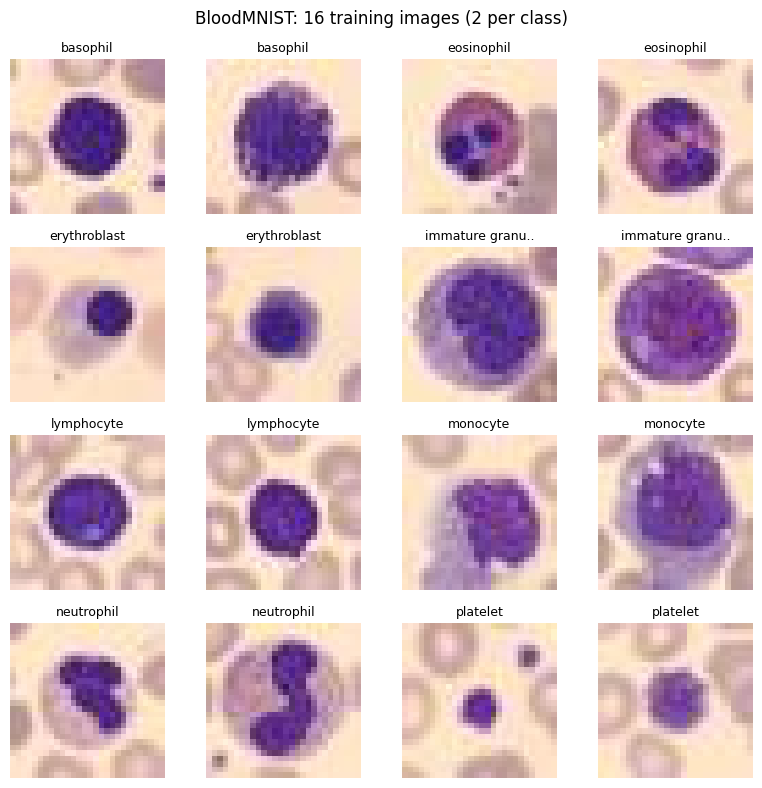

In [11]:
# --- Task 3: Display a grid of 16 random training images (2 per class) with class labels ---
indices_per_class = {i: [] for i in range(num_classes)}
for idx, (img, target) in enumerate(train_dataset):
    y = int(target.squeeze() if hasattr(target, "squeeze") else target)
    if len(indices_per_class[y]) < 2:
        indices_per_class[y].append(idx)
    if all(len(v) == 2 for v in indices_per_class.values()):
        break

selected = [idx for c in range(num_classes) for idx in indices_per_class[c]]
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax, idx in zip(axes.flatten(), selected):
    img, target = train_dataset[idx]
    y = int(target.squeeze() if hasattr(target, "squeeze") else target)
    disp = img.permute(1, 2, 0).numpy() if img.dim() == 3 else img.squeeze().numpy()
    ax.imshow(disp, cmap="gray" if disp.ndim == 2 else None)
    title = class_names[y][:14] + (".." if len(class_names[y]) > 14 else "")
    ax.set_title(title, fontsize=9)
    ax.axis("off")
plt.suptitle("BloodMNIST: 16 training images (2 per class)")
plt.tight_layout()
plt.show()

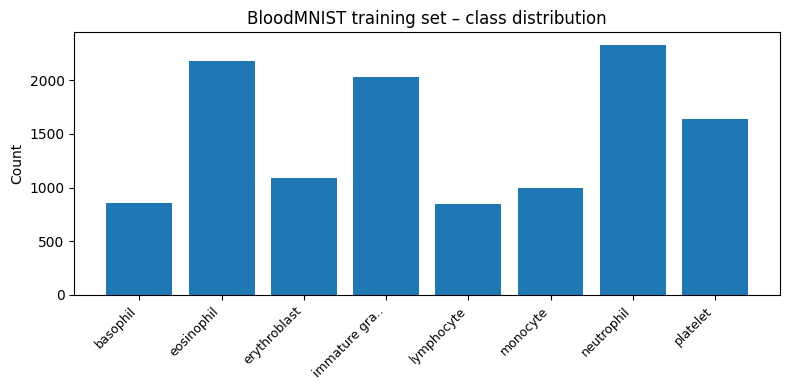

Class distribution (train):
  basophil                 :  852 (7.1%)
  eosinophil               : 2181 (18.2%)
  erythroblast             : 1085 (9.1%)
  immature granulocytes(myelocytes, metamyelocytes and promyelocytes): 2026 (16.9%)
  lymphocyte               :  849 (7.1%)
  monocyte                 :  993 (8.3%)
  neutrophil               : 2330 (19.5%)
  platelet                 : 1643 (13.7%)

Max: 2330 (neutrophil), Min: 849 (lymphocyte)
The dataset is not balanced: some classes have many more samples than others (e.g. neutrophil vs basophil).


In [12]:
# --- Task 4: Plot class distribution (bar chart) for training set; comment on balance ---
class_counts = np.zeros(num_classes, dtype=int)
for _, target in train_dataset:
    y = int(target.squeeze() if hasattr(target, "squeeze") else target)
    class_counts[y] += 1

plt.figure(figsize=(8, 4))
plt.bar(range(num_classes), class_counts)
# Shorten long class names for x-axis so the 4th class (e.g. immature granulocytes) fits
short_names = [s[:12] + ".." if len(s) > 12 else s for s in class_names]
plt.xticks(range(num_classes), short_names, rotation=45, ha="right", fontsize=9)
plt.ylabel("Count")
plt.title("BloodMNIST training set – class distribution")
plt.tight_layout()
plt.show()

# Distribution analysis
print("Class distribution (train):")
for i in range(num_classes):
    print(f"  {class_names[i]:25s}: {class_counts[i]:4d} ({100*class_counts[i]/class_counts.sum():.1f}%)")
print(f"\nMax: {class_counts.max()} ({class_names[class_counts.argmax()]}), Min: {class_counts.min()} ({class_names[class_counts.argmin()]})")
print("The dataset is not balanced: some classes have many more samples than others (e.g. neutrophil vs basophil).")

### Q4.2: Build and Train an MLP (5 points)

1. Flatten each 28×28×3 RGB image into a **2,352-dimensional** input vector  
2. Build a 3-layer MLP: **Input 2352 → Hidden 1: 256 (ReLU) → Hidden 2: 128 (ReLU) → Output: 8**  
3. **Adam** optimizer, lr=1e-3, **CrossEntropyLoss**  
4. Train for **30 epochs**, batch size **64**  
5. Plot **training loss** and **validation loss** (same figure)  
6. Plot **training accuracy** and **validation accuracy** (same figure)

In [13]:
# --- Q4.2: DataLoaders and device ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [14]:
# --- Q4.2: 3-layer MLP (2352 → 256 ReLU → 128 ReLU → 8) ---
class BloodMLP(nn.Module):
    def __init__(self):
        super(BloodMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
# --- Q4.2: Model, optimizer, loss ---
model = BloodMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [16]:
# --- Q4.2: Train for 30 epochs, record train/val loss and accuracy ---
num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze().long()
            logits = model(images)
            val_loss += criterion(logits, labels).item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_losses[-1]:.4f} Acc: {train_accs[-1]:.4f}  |  Val Loss: {val_losses[-1]:.4f} Acc: {val_accs[-1]:.4f}")

Epoch 1/30  Train Loss: 1.2534 Acc: 0.5322  |  Val Loss: 0.9025 Acc: 0.6583
Epoch 2/30  Train Loss: 0.8898 Acc: 0.6747  |  Val Loss: 0.7746 Acc: 0.7109
Epoch 3/30  Train Loss: 0.8050 Acc: 0.7062  |  Val Loss: 0.8001 Acc: 0.6805
Epoch 4/30  Train Loss: 0.7621 Acc: 0.7164  |  Val Loss: 0.6630 Acc: 0.7576
Epoch 5/30  Train Loss: 0.6974 Acc: 0.7444  |  Val Loss: 0.6148 Acc: 0.7862
Epoch 6/30  Train Loss: 0.6763 Acc: 0.7482  |  Val Loss: 0.6244 Acc: 0.7710
Epoch 7/30  Train Loss: 0.6333 Acc: 0.7669  |  Val Loss: 0.6758 Acc: 0.7494
Epoch 8/30  Train Loss: 0.5980 Acc: 0.7836  |  Val Loss: 0.5456 Acc: 0.7856
Epoch 9/30  Train Loss: 0.5835 Acc: 0.7849  |  Val Loss: 0.5466 Acc: 0.7996
Epoch 10/30  Train Loss: 0.5648 Acc: 0.7930  |  Val Loss: 0.5073 Acc: 0.8067
Epoch 11/30  Train Loss: 0.5337 Acc: 0.8042  |  Val Loss: 0.5134 Acc: 0.8172
Epoch 12/30  Train Loss: 0.5503 Acc: 0.7965  |  Val Loss: 0.6021 Acc: 0.7862
Epoch 13/30  Train Loss: 0.5283 Acc: 0.8057  |  Val Loss: 0.5374 Acc: 0.8008
Epoch 14

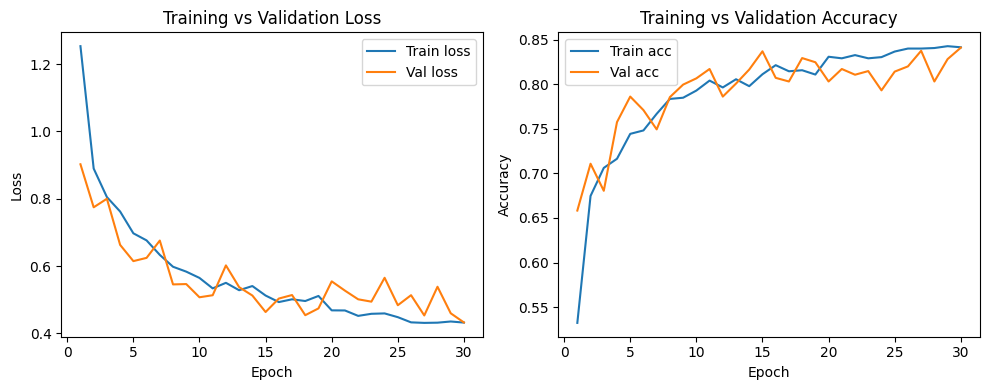

In [17]:
# --- Q4.2: Plot training vs validation loss and accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, train_losses, label="Train loss")
ax1.plot(epochs, val_losses, label="Val loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()

ax2.plot(epochs, train_accs, label="Train acc")
ax2.plot(epochs, val_accs, label="Val acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()
plt.tight_layout()
plt.show()

### Q4.3: Evaluation and Analysis (5 points)

1. Report the **final test accuracy** (as a percentage)  
2. Generate a **confusion matrix** (8×8) for the test set using `sklearn.metrics.confusion_matrix` and visualize it as a **heatmap** with class labels  
3. Identify the **two most confused cell type pairs** (highest off-diagonal values)  
4. Compute and report **per-class precision and recall** using `sklearn.metrics.classification_report`  
5. Which cell type has the **lowest recall**? Examine **5 misclassified examples** of this cell type and hypothesize why the model struggles with it.

In [18]:
# --- Q4.3.1: Final test accuracy ---
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long()
        logits = model(images)
        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

test_acc = 100.0 * (all_preds == all_labels).mean()
print(f"Final test accuracy: {test_acc:.2f}%")

Final test accuracy: 82.96%


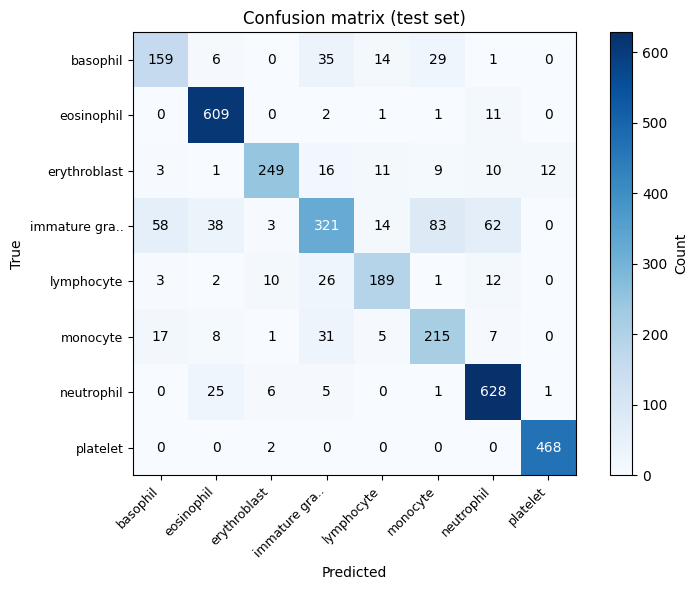

In [20]:
# --- Q4.3.2: Confusion matrix (8×8) heatmap with class labels ---
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, label="Count")
ax.set_xticks(range(8))
ax.set_yticks(range(8))
short_names = [s[:12] + '..' if len(s) > 12 else s for s in class_names]
ax.set_xticklabels(short_names, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(short_names, fontsize=9)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(8):
    for j in range(8):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white")
plt.title("Confusion matrix (test set)")
plt.tight_layout()
plt.show()

In [21]:
# --- Q4.3.3: Two most confused cell type pairs (highest off-diagonal) ---
# Copy cm and zero out diagonal to get only off-diagonal
cm_off = cm.copy()
for i in range(8):
    cm_off[i, i] = 0

# Find indices of 2 largest off-diagonal values (flat index)
flat = cm_off.flatten()
top2_flat = np.argsort(flat)[-2:][::-1]
for idx in top2_flat:
    i, j = idx // 8, idx % 8
    print(f"  {class_names[i]} predicted as {class_names[j]}: {cm[i, j]} times")
print("(Two most confused pairs above.)")

  immature granulocytes(myelocytes, metamyelocytes and promyelocytes) predicted as monocyte: 83 times
  immature granulocytes(myelocytes, metamyelocytes and promyelocytes) predicted as neutrophil: 62 times
(Two most confused pairs above.)


In [24]:
# --- Q4.3.4: Per-class precision and recall (classification_report) ---
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

                                                                     precision    recall  f1-score   support

                                                           basophil      0.662     0.652     0.657       244
                                                         eosinophil      0.884     0.976     0.928       624
                                                       erythroblast      0.919     0.801     0.856       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)      0.736     0.554     0.633       579
                                                         lymphocyte      0.808     0.778     0.792       243
                                                           monocyte      0.634     0.757     0.690       284
                                                         neutrophil      0.859     0.943     0.899       666
                                                           platelet      0.973     0.996     0.984       470

                 

Cell type with lowest recall: immature granulocytes(myelocytes, metamyelocytes and promyelocytes) (recall = 0.554)


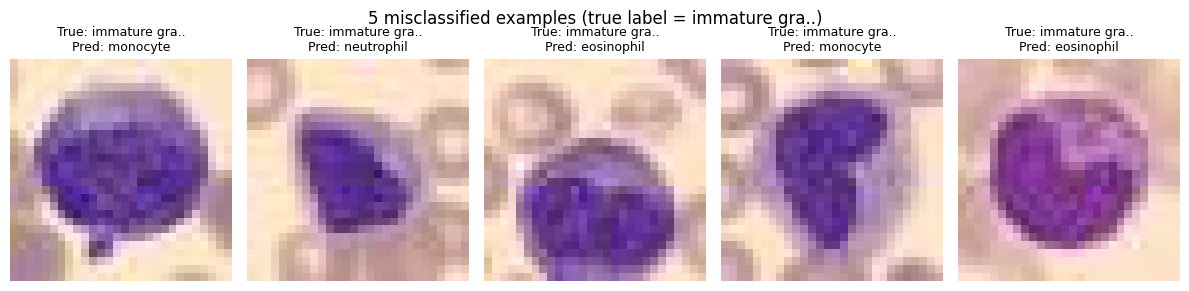

In [25]:
# --- Q4.3.5: Cell type with lowest recall; show 5 misclassified examples ---
from sklearn.metrics import precision_recall_fscore_support
precision, recall, _, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
lowest_recall_class = int(np.argmin(recall))
print(f"Cell type with lowest recall: {class_names[lowest_recall_class]} (recall = {recall[lowest_recall_class]:.3f})")

# Indices in test set where true=lowest_recall_class but predicted != lowest_recall_class
mis_mask = (all_labels == lowest_recall_class) & (all_preds != lowest_recall_class)
mis_indices = np.where(mis_mask)[0][:5]

short_names = [s[:12] + '..' if len(s) > 12 else s for s in class_names]
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax, idx in zip(axes, mis_indices):
    img, _ = test_dataset[idx]
    true_lab = all_labels[idx]
    pred_lab = all_preds[idx]
    disp = img.permute(1, 2, 0).numpy() if img.dim() == 3 else img.squeeze().numpy()
    ax.imshow(disp, cmap="gray" if disp.ndim == 2 else None)
    ax.set_title(f"True: {short_names[true_lab]}\nPred: {short_names[pred_lab]}", fontsize=9)
    ax.axis("off")
plt.suptitle(f"5 misclassified examples (true label = {short_names[lowest_recall_class]})")
plt.tight_layout()
plt.show()

**Hypothesis (why the model struggles with this cell type):**  
The class with lowest recall is often a minority class or one that is visually similar to others (e.g. immature granulocytes vs neutrophils). The model may confuse it with the most confused pair identified above, or the training set may have few examples. Inspect the 5 misclassified images: shared appearance (size, shape, color) with the predicted class can explain the errors.

### Q4.4: Prediction Confidence Analysis (3 points)

Categorize predictions into four quadrants by **confidence** (max softmax prob) and **correctness**:
- **High confidence**: max prob > 0.9  
- **Low confidence**: max prob < 0.6  

| | Correct | Incorrect |
|---|---------|-----------|
| **High confidence** | ✓ Confident | ✗ Confident |
| **Low confidence** | ✓ Uncertain | ✗ Uncertain |

1. Find and display **2 examples from each quadrant** (8 images total) with: image, true label, predicted label, prediction confidence.  
2. **Written analysis (3–4 sentences)**: What distinguishes "Incorrect but Confident" examples? Why might the model be overconfident?

In [26]:
# --- Q4.4: Get max softmax probability for each test sample ---
model.eval()
all_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1)
        max_prob, _ = probs.max(dim=1)
        all_probs.append(max_prob.cpu().numpy())
all_probs = np.concatenate(all_probs)

correct = (all_preds == all_labels)
high_conf = (all_probs > 0.9)
low_conf = (all_probs < 0.6)

# Four quadrants: (correct, high), (correct, low), (incorrect, high), (incorrect, low)
quadrants = [
    ("Correct, High conf", np.where(correct & high_conf)[0]),
    ("Correct, Low conf",  np.where(correct & low_conf)[0]),
    ("Incorrect, High conf", np.where(~correct & high_conf)[0]),
    ("Incorrect, Low conf",  np.where(~correct & low_conf)[0]),
]
for name, idx in quadrants:
    print(f"  {name}: {len(idx)} samples")

  Correct, High conf: 1927 samples
  Correct, Low conf: 287 samples
  Incorrect, High conf: 53 samples
  Incorrect, Low conf: 302 samples


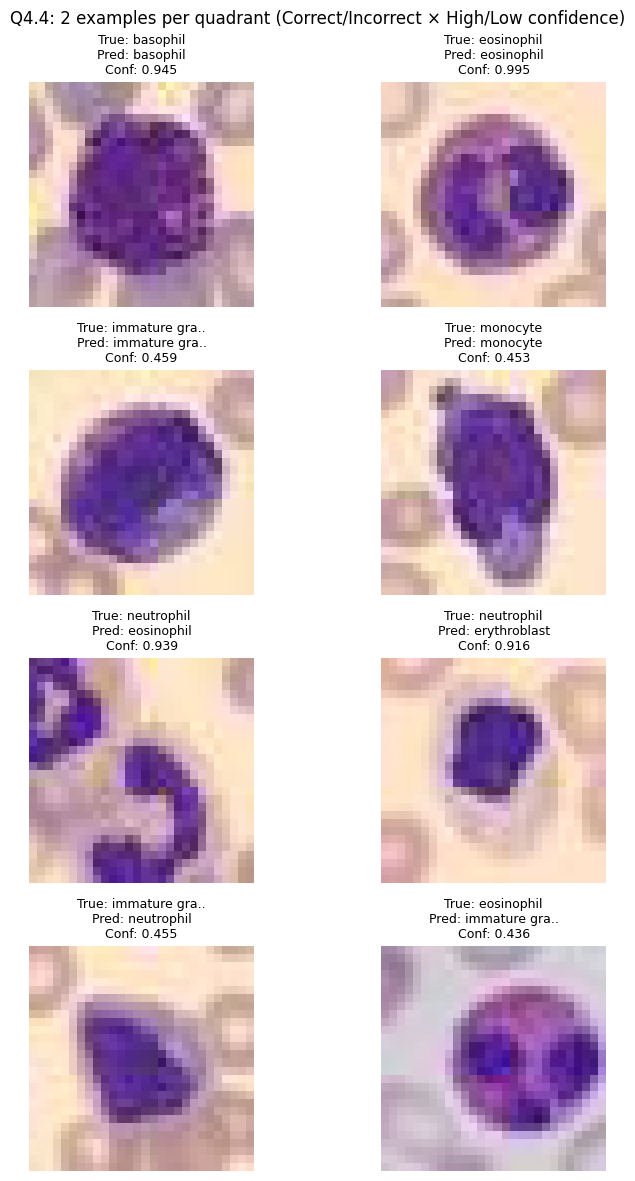

In [27]:
# --- Q4.4: Display 2 examples from each quadrant (8 images total) ---
short_names = [s[:12] + ".." if len(s) > 12 else s for s in class_names]
fig, axes = plt.subplots(4, 2, figsize=(8, 12))
for row, (quad_name, indices) in enumerate(quadrants):
    chosen = indices[:2]
    for col, idx in enumerate(chosen):
        ax = axes[row, col]
        img, _ = test_dataset[idx]
        disp = img.permute(1, 2, 0).numpy() if img.dim() == 3 else img.squeeze().numpy()
        ax.imshow(disp, cmap="gray" if disp.ndim == 2 else None)
        true_lab = all_labels[idx]
        pred_lab = all_preds[idx]
        conf = all_probs[idx]
        ax.set_title(f"True: {short_names[true_lab]}\nPred: {short_names[pred_lab]}\nConf: {conf:.3f}", fontsize=9)
        ax.axis("off")
    axes[row, 0].set_ylabel(quad_name, fontsize=10)
plt.suptitle("Q4.4: 2 examples per quadrant (Correct/Incorrect × High/Low confidence)")
plt.tight_layout()
plt.show()

**Written analysis (3–4 sentences):**  
The "Incorrect but Confident" examples are cases where the model assigns high probability (>0.9) to the wrong class. Often these are cell types that look visually similar to the predicted class (e.g. granulocytes vs neutrophils, or similar staining and shape), so the model has learned features that confidently but wrongly distinguish them. The model may be overconfident on these because the training data or the 28×28 resolution does not capture the subtle differences that a pathologist would use, so the classifier relies on strong but misleading cues and assigns high confidence to the wrong class.